<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Install lib**

In [ ]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



In [ ]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

In [ ]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [ ]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install sumy

# **Processing data**

In [ ]:
size_data_test = 2

In [ ]:
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/meeting/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/meeting/002.txt
/content/drive/MyDrive/LLM_TEXT/dataset/meeting/012.txt


In [ ]:
import os
# Tạo data  tham chiếu nhiệm vụ trích xuất nhiệm vụ
def writeFile(path_file):
  """
  Input: Path of txt file
  Output
  """
  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""
  summary_taskDict = []
  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0

      path = "/content/drive/MyDrive/LLM_TEXT/dataset/meeting_Data_Task_Original/"
      file_name = os.path.basename(path_file)
      path_save = path + file_name
      f = open(path_save, "w")
      print("Save file ---> "+ path_save)

      linen = True
      for line in lines:
          line = line.strip()

          if "NOI_DUNG_TOM_TAT" in line:
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif "NHIEM_VU" in line:#line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          elif line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")

          line += " "
          line = line.strip()
          if line == "":
            continue
          if line:
            if cnt == 2:
              # print(line)
              f.write(line)
              f.write("\n")

      f.close()


In [ ]:
# for file in test_paths:
#   writeFile(file)

In [ ]:
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """

  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""

  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      for line in lines:
          line = line.strip()

          if line.startswith("NOI_DUNG_TOM_TAT"):
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          elif line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")
          if line:
            if cnt == 1:
              summary_content += line
            elif cnt == 2:
              summary_task += line
            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  return {'file' : path_file,
          'summary_task': summary_task,
          'summary_content': summary_content,
          'original': original}

In [ ]:
def get_stop_words_vn(path):
    ret = []
    # path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
# print("stop_words", stop_words)
print("task_words", task_words)

task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ', ' đảm nhận ']


In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:
test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_task"], test_df["summary_content"] )

test_df 0    Phương sẽ đảm nhận vai trò chính trong việc th...
1    Lam sẽ đảm nhận vai trò chính trong việc phát ...
Name: summary_task, dtype: object 0    Trong cuộc họp giao nhiệm vụ của công ty Vạn H...
1    Phân công nhiệm vụ code chức năng review cho h...
Name: summary_content, dtype: object


In [ ]:
test_data =  Dataset.from_pandas(test_df)

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

# **Summary task**

Trích xuất nhiệm vụ

In [ ]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer_nvu = AutoTokenizer.from_pretrained('vinai/phobert-base')
model_nvu = AutoModel.from_pretrained('vinai/phobert-base')

# chức năng chia nhỏ đoạn văn thành các đoạn nhỏ sử dụng text segmentation in NLP
def content_sentences( body: str, min_length=5, max_length=200):
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

# Sử dụng PhoBERT để convert text thành các dạng vector
def encode_sentences(sentences):
    encoded_inputs = tokenizer_nvu(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model_nvu(**encoded_inputs)
    return model_output.pooler_output

# Đánh giá sự tương đồng của 2 đoạn (về nội dung, ngữ nghĩa) => trả về giá trị 0 - 1.0
def calculate_cosine_similarity(sentence_infer_embedding, sentence2):
    sentence2_embedding = encode_sentences(sentence2)
    similarity_score = cosine_similarity(sentence_infer_embedding, sentence2_embedding)
    return similarity_score[0][0]



# Ví dụ:
sentence1 = "Quỳnh nhận nhiệm vụ sẽ tuyên truyền giáo dục An toàn giao thông cho học sinh vào các giờ chào cờ đầu tuần."
sentence2 = "Trường THCS kim Liên diễn ra cuộc họp của ban trung tâm bàn nội dung công việc và nhiệm vụ thực hiện của tháng 5.."

sentence_infer_embedding = encode_sentences(sentence1)
similarity_percentage = calculate_cosine_similarity(sentence_infer_embedding, sentence2)
print(f"Độ giống nhau: {similarity_percentage:.2f}%")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Độ giống nhau: 0.47%


In [ ]:
def compare_task(sentence, threshould_ = 0.9):
  pre = -1
  for task_infer in inferrence_Task_embedding:
    ret = calculate_cosine_similarity(task_infer, sentence)
    if ret > pre:
      pre = ret
    if ret > threshould_ :
      return ret
  return pre

Tạo data tham chiếu

In [ ]:
import os
inferrence_Task_embedding = [] # Tạo list data để làm dữ liệu tham chiếu cho việc trích xuất nhiệm vụ

for path_file in test_paths:
   file_name = os.path.basename(path_file)
   path_file_data = "/content/drive/MyDrive/LLM_TEXT/dataset/meeting_Data_Task_Original/" + file_name
   with open(path_file_data, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      for line in lines:
          line = line.strip()
          sentences = content_sentences(line, 1, 400)
          for sentence in sentences:
            # print("sentence ", sentence )
            encode_sentence_ = encode_sentences(sentence)
            inferrence_Task_embedding.append(encode_sentence_)
            break

print("length of inferrence_Task_embedding: ", len(inferrence_Task_embedding))

length of inferrence_Task_embedding:  7


In [ ]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import re
THRESHOLD = 0.9
def contains_digits(input_str):
    digit_pattern = r'\d'
    match = re.search(digit_pattern, input_str)
    return match is not None

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str, case1 = True):
  sentences = process_content_sentences(str, 1, 400)
  ret = ""
  for sentence in sentences:
    sentencelower = sentence.lower()
    time = ""
    # for wTime in time_words:
    #   if wTime.strip() in sentencelower:
    #       time = sentencelower
    #       try:
    #         if contains_digits(time):
    #           ret[-1]["time"] = time
    #           # print("time ", time)
    #       except:
    #         pass

    #       break
    preci_ = compare_task(sentence, THRESHOLD)
    # for wTask in task_words:
    #   if wTask.strip() in sentencelower:
    if preci_ >= THRESHOLD:
      ret += sentence

  return ret


In [ ]:
def detectTaskKeyword(str):
  sentences = process_content_sentences(str, 1, 400)
  ret = ""
  for sentence in sentences:
    sentence = sentence.lower()
    for wTask in task_words:
      if wTask.strip() in sentence:
        # for word in reversed(stop_words):
        #   sentence = sentence.replace(word, " ")
        for word in reversed(stop_words):
          sentence = sentence.replace(word, " ")
        # print(sentence)
        ret += sentence
        break
  return ret

# **Inference**

In [ ]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_2/"
RATIO = 0.2
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
rougel_recall = []
rougel_precision = []
rougel_f1 = []

In [ ]:
def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

## **With my model**

In [ ]:
myModelName = 'Custom "Custom PhoBERT"'

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/trainning_summary_content_bbch/checkpoint-8000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [ ]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]
summary_task_original = results["summary_task"]


print ("result_summary_content: ",result_summary_content[0] )

print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
print ("summary_task: ",summary_task_original[0] )
print ("original: ",test_data[0]["original"] )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  Trong cuộc họp giao nhiệm vụ của công ty Vạn Hoa đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong
file:  /content/drive/MyDrive/LLM_TEXT/dataset/meeting/012.txt
summary_conten:  Trong cuộc họp giao nhiệm vụ của công ty Vạn Hoa đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm.
summary_task:  Phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (UI) và trang chủ. Nhiệm vụ của Phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần UI cần thiết.Anh  sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên. Nhiệm vụ: Phát triển chức năng quản lý nhân viên, bao gồm thêm/xóa/sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.Linh sẽ đảm nhận nhiệm vụ xây dựng chức năng quản lý bộ phận, Thiết kế và triển khai chức năng quản lý bộ phận, bao gồm tạo/biên tập/x

In [ ]:
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data)
  result_summary_task.append(ret_task)
  print("data", data)
  print('--->',ret_task, "\n")

data Trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm. Dưới đây là phân công cụ thể và deadline cho mỗi thành viên: Phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (UI) và trang chủ. Nhiệm vụ của Phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần UI cần thiết.Anh  sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên. Nhiệm vụ: Phát triển chức năng quản lý nhân viên, bao gồm thêm/xóa/sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.Linh sẽ đảm nhận nhiệm vụ xây dựng chức năng quản lý bộ phận, Thiết kế và triển khai chức năng quản lý bộ phận, bao gồm tạo/biên tập/xóa bộ phận, hiển thị danh sách bộ phận, và phân loại nhân viên theo bộ phận.Dương sẽ đảm nhận vai trò xây dựng chức năng quản lý công việc. Xây dựng chức năng quản lý công việc của nhân viê

In [ ]:
result_summary_task_keyword = []
for data in test_df["original"]:
  ret_task = detectTaskKeyword(data)
  result_summary_task_keyword.append(ret_task)
  print("data", data)
  print('--->',ret_task, "\n")

data Trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm. Dưới đây là phân công cụ thể và deadline cho mỗi thành viên: Phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (UI) và trang chủ. Nhiệm vụ của Phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần UI cần thiết.Anh  sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên. Nhiệm vụ: Phát triển chức năng quản lý nhân viên, bao gồm thêm/xóa/sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.Linh sẽ đảm nhận nhiệm vụ xây dựng chức năng quản lý bộ phận, Thiết kế và triển khai chức năng quản lý bộ phận, bao gồm tạo/biên tập/xóa bộ phận, hiển thị danh sách bộ phận, và phân loại nhân viên theo bộ phận.Dương sẽ đảm nhận vai trò xây dựng chức năng quản lý công việc. Xây dựng chức năng quản lý công việc của nhân viê

## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]

In [ ]:
import os
import re

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) +" "
  write_data(path, 0, idx, result)

In [ ]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk

#SENTENCES_COUNT = 3
path_file_stopword = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
# print(test_df)
if __name__ == "__main__":

    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    for idx, originnalTxt in enumerate(test_df["original"]):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(originnalTxt), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


    # for sentence in summarizer(parser.document, SENTENCES_COUNT):
    #     print(sentence)

0
allnumber: []
all_dot []
text_dot: []
1
allnumber: []
all_dot []
text_dot: []


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []

    print("model: ", model)
    ret_rouge_ = rouge.compute(predictions=data_sum, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
    # for key,value in ret_rouge_.items():
    #   print(key)
    #   print(value.mid)

    getRougeMyModel(ret_rouge_)

In [ ]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)


# getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.3753858024691358 -precision 0.75 -F1-Score 0.4582730840735385
rouge2:recall 0.2163563829787234 -precision 0.5888888888888889 -F1-Score 0.29487731381833837
rougeL:recall 0.3128858024691358 -precision 0.6847826086956521 -F1-Score 0.39444329683949597
model:  LexRankSummarizer
rouge1:recall 0.32263513513513514 -precision 0.7806324110671936 -F1-Score 0.44642857142857145
rouge2:recall 0.15181203398647475 -precision 0.40793650793650793 -F1-Score 0.21636925188743994
rougeL:recall 0.24560810810810813 -precision 0.6027667984189724 -F1-Score 0.3412698412698413
model:  LsaSummarizer
rouge1:recall 0.42674157303370785 -precision 0.7796442687747036 -F1-Score 0.5045045045045045
rouge2:recall 0.16906307977736548 -precision 0.3603174603174603 -F1-Score 0.20876439586179973
rougeL:recall 0.2886516853932584 -precision 0.5464426877470355 -F1-Score 0.34487612612612606
model:  LuhnSummarizer
rouge1:recall 0.23371448371448372 -precision 0.8804347826086957 -F1-Score 0.364277

# **Evaluation**


In [ ]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
models.append(myModelName)
getRougeMyModel(rouge_summary_content)


Evaluation content
rouge1:recall 0.6704545454545454 -precision 0.8191699604743083 -F1-Score 0.7161616161616161
rouge2:recall 0.5697674418604651 -precision 0.6206349206349207 -F1-Score 0.5823863636363636
rougeL:recall 0.625 -precision 0.7282608695652174 -F1-Score 0.6555555555555556


In [ ]:
print("Evaluation task (cosine similarity)")
rouge_summary_task = rouge.compute(predictions=result_summary_task, references=summary_task_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_task.items():
  print(key)
  print(value.mid)

Evaluation task (cosine similarity)
rouge1
Score(precision=0.993421052631579, recall=0.38718820861678005, fmeasure=0.5570929419986024)
rouge2
Score(precision=0.9066666666666667, recall=0.3502135821951352, fmeasure=0.5051733642415932)
rougeL
Score(precision=0.875, recall=0.3395691609977324, fmeasure=0.4891684136967156)


In [ ]:
print("Evaluation task with keyword")
rouge_summary_task_keyword = rouge.compute(predictions=result_summary_task_keyword, references=summary_task_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_task_keyword.items():
  print(key)
  print(value.mid)

Evaluation task with keyword
rouge1
Score(precision=0.9213842975206612, recall=0.6757369614512472, fmeasure=0.7769119246103662)
rouge2
Score(precision=0.6209770114942529, recall=0.4637182347499592, fmeasure=0.5291567587342235)
rougeL
Score(precision=0.7143595041322315, recall=0.5343915343915344, fmeasure=0.6093874592243566)


# **Draw a comparison chart**

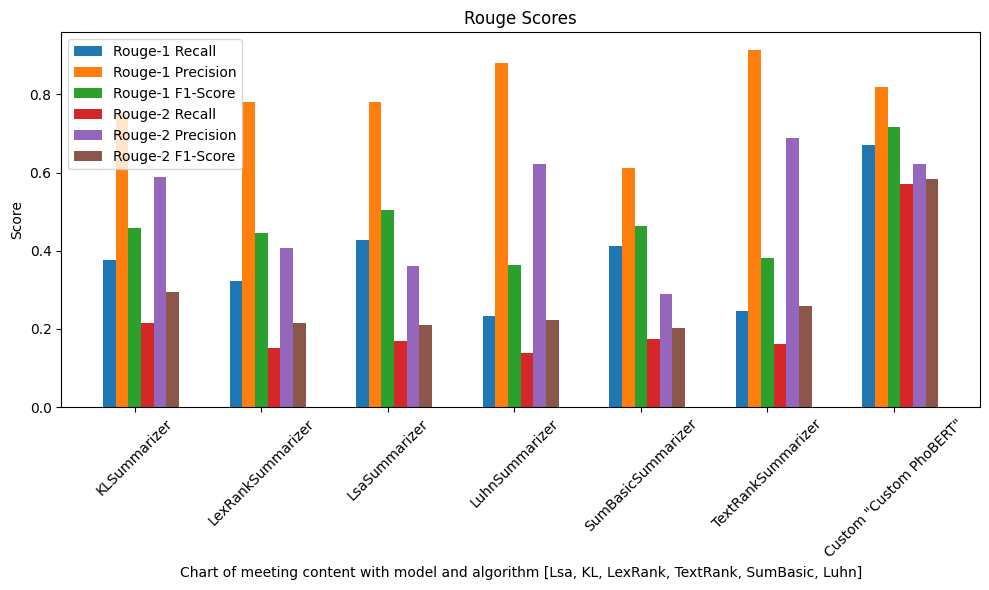

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Chart of meeting content with model and algorithm [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def getRouge(data_rouge):
  for key,value in data_rouge.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[0])
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall_task.append(value.mid[0])
         rouge2_precision_task.append(value.mid[1])
         rouge2_f1_task.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

In [ ]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
rouge2_recall_task = []
rouge2_precision_task = []
rouge2_f1_task = []
models_task = ["With keyword", "With cosine similarity"]

print("With keyword")
getRouge(rouge_summary_task_keyword)

print("With cosine similarity")
getRouge(rouge_summary_task)


With keyword
rouge1:recall 0.9213842975206612 -precision 0.6757369614512472 -F1-Score 0.7769119246103662
rouge2:recall 0.6209770114942529 -precision 0.4637182347499592 -F1-Score 0.5291567587342235
rougeL:recall 0.7143595041322315 -precision 0.5343915343915344 -F1-Score 0.6093874592243566
With cosine similarity
rouge1:recall 0.993421052631579 -precision 0.38718820861678005 -F1-Score 0.5570929419986024
rouge2:recall 0.9066666666666667 -precision 0.3502135821951352 -F1-Score 0.5051733642415932
rougeL:recall 0.875 -precision 0.3395691609977324 -F1-Score 0.4891684136967156


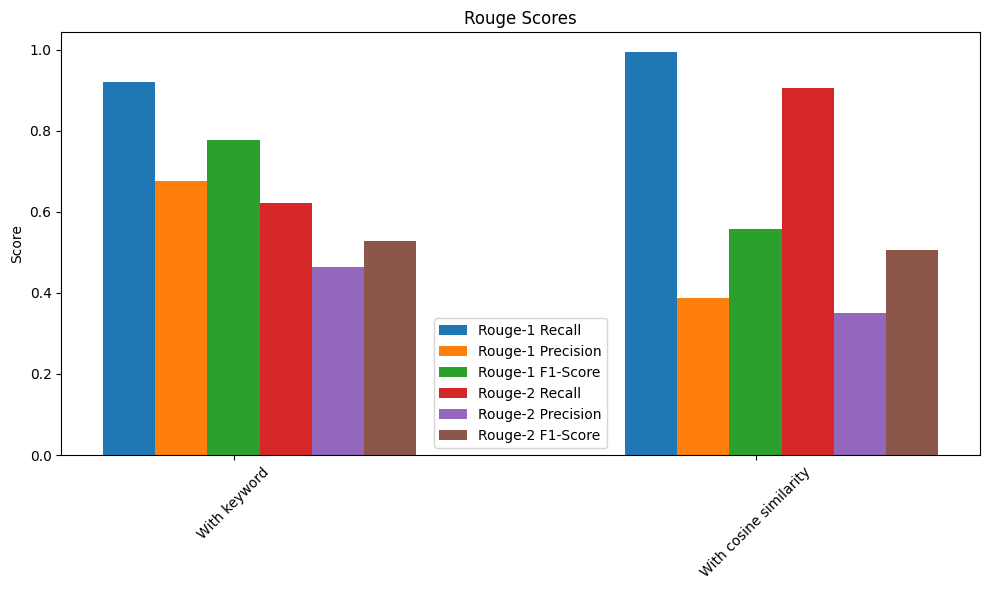

In [ ]:

import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()